Data Set Information:

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.


Attribute Information:

This problem has the following inputs: 
1. Frequency, in Hertzs. 
2. Angle of attack, in degrees. 
3. Chord length, in meters. 
4. Free-stream velocity, in meters per second. 
5. Suction side displacement thickness, in meters. 

The only output is: 
6. Scaled sound pressure level, in decibels. 

https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise#

The main goal of this project, is to find the best regression model to predict the sound pressure level.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
import pickle

import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_csv('AirfoilSelfNoise.csv')

In [36]:
df

,f,alpha,c,U_infinity,delta,SSPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   f           1503 non-null   int64  
 1   alpha       1503 non-null   float64
 2   c           1503 non-null   float64
 3   U_infinity  1503 non-null   float64
 4   delta       1503 non-null   float64
 5   SSPL        1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [38]:
df.describe()

,f,alpha,c,U_infinity,delta,SSPL
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


Let's check distribution of each variable

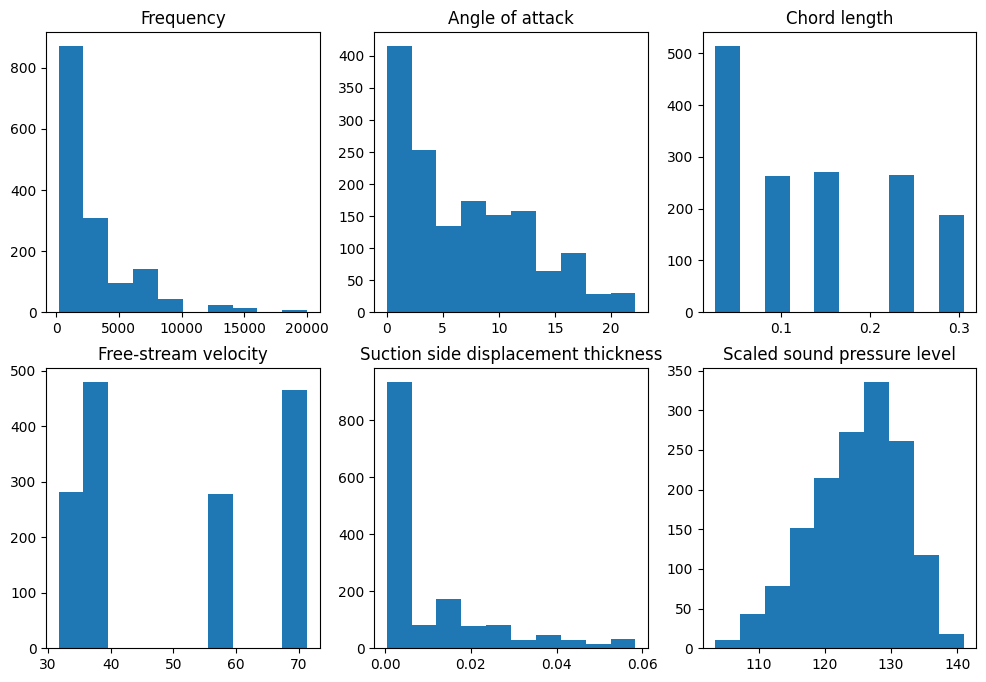

In [39]:
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=3)
axes[0, 0].hist(df['f'])
axes[0, 1].hist(df['alpha'])
axes[0, 2].hist(df['c'])
axes[1, 0].hist(df['U_infinity'])
axes[1, 1].hist(df['delta'])
axes[1, 2].hist(df['SSPL'])
axes[0][0].set_title("Frequency")
axes[0][1].set_title("Angle of attack")
axes[0][2].set_title("Chord length")
axes[1][0].set_title("Free-stream velocity")
axes[1][1].set_title("Suction side displacement thickness")
axes[1][2].set_title("Scaled sound pressure level")
plt.show()

Let's chcek how each variable is correlated with target

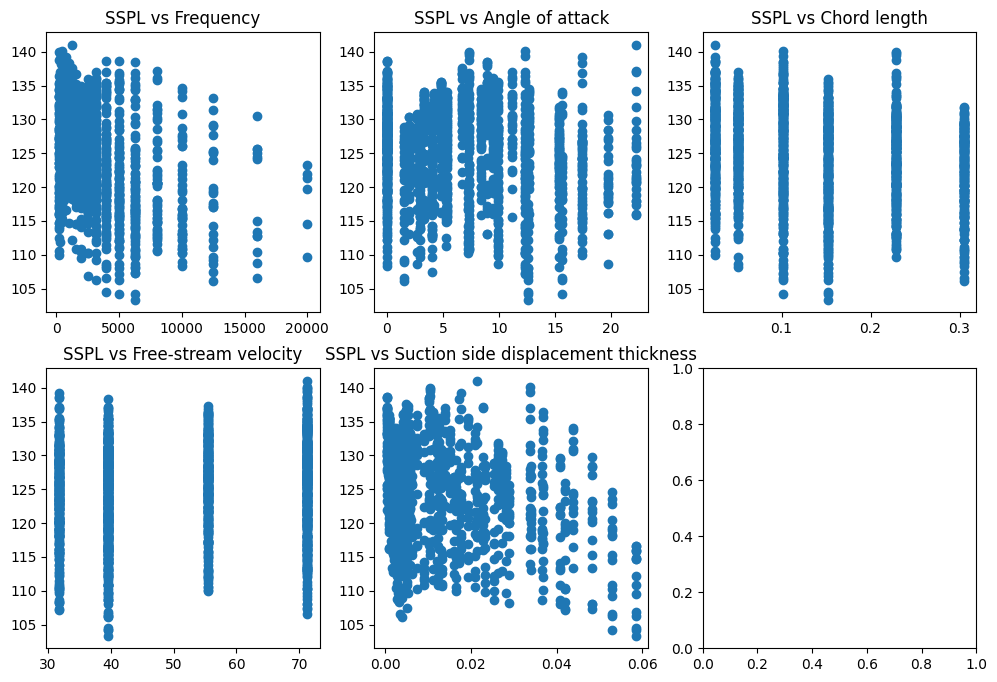

In [40]:
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=3)
axes[0, 0].scatter(df['f'], df['SSPL'])
axes[0, 1].scatter(df['alpha'], df['SSPL'])
axes[0, 2].scatter(df['c'], df['SSPL'])
axes[1, 0].scatter(df['U_infinity'], df['SSPL'])
axes[1, 1].scatter(df['delta'], df['SSPL'])
axes[0][0].set_title("SSPL vs Frequency")
axes[0][1].set_title("SSPL vs Angle of attack")
axes[0][2].set_title("SSPL vs Chord length")
axes[1][0].set_title("SSPL vs Free-stream velocity")
axes[1][1].set_title("SSPL vs Suction side displacement thickness")
plt.show()

## Model for diagnosis

In [41]:
columns = list(df.columns)
columns.remove('SSPL')
features = '+'.join(columns)
model = smf.ols('SSPL~'+features, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SSPL   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     318.8
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.15e-232
Time:                        10:32:32   Log-Likelihood:                -4490.1
No. Observations:                1503   AIC:                             8992.
Df Residuals:                    1497   BIC:                             9024.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.8338      0.545    243.866      0.000     131.765     133.902
f             -0.0013   4.21e-05    -30.452      0.000      -0.001      -0.001
alpha         -0.4219      0.039    -10.847      0.000      -0.498      -0.346
c            -35.6880      1.630    -21.889      0.000     -38.886     -32.490
U_infinity     0.0999      0.008     12.279      0.000       0.084       0.116
delta       -147.3005     15.015     -9.810      0.000    -176.753    -117.848
==============================================================================
Omnibus:                       12.947   Durbin-Watson:                   0.447
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.228
Skew:                          -0.020   Prob(JB):                     6.68e-05
Kurtosis:                       3.553   Cond. No.                     5.18e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
print("P-value for F test (Prob (F-statistic)): {}".format(model.f_pvalue))

P-value for F test (Prob (F-statistic)): 1.1476339560359335e-232


P-value for Fstatistics is close to zero, so we reject the null hipotesis (H0). It means that at least one of the coefficients of the variables is non-zero, that is, at least one variable affects the SSPL.
P-value for P>|t| for each feature is close to zero, which also means that each feature affects the SSPL.

P-values for Omnibus and Jarque-Bera tests are also close to zero. It means that the residuals are not normally distributed. <br>
Approximately 50% (R-squared) of the SSPL is explained by the given variables.

## Modeling

In [43]:
X = df.iloc[:,:5]
y = df['SSPL']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [45]:
def compute_metrics(model):

    r2 = model.score(X_train, y_train)
    fitted_values = model.predict(X_train)
    mse_train = metrics.mean_squared_error(y_train, fitted_values)
    mae_train = metrics.median_absolute_error(y_train, fitted_values)

    y_pred = model.predict(X_test)
    mse_test = metrics.mean_squared_error(y_test, y_pred)
    mae_test = metrics.median_absolute_error(y_test, y_pred)
    
    return {
        'r2': r2, 'mse_train': mse_train, 'mae_train': mae_train, 'mse_test': mse_test, 'mae_test': mae_test
    }

In [46]:
results = pd.DataFrame(index=['r2', 'mse_train', 'mae_train', 'mse_test', 'mae_test'])

#### Baseline

In [47]:
LR_baseline = LinearRegression()
LR_baseline.fit(X=X_train, y=y_train)

LinearRegression()

In [48]:
results['LinReg'] = compute_metrics(LR_baseline).values()
results

,LinReg
r2,0.514173
mse_train,22.467746
mae_train,2.875216
mse_test,24.390002
mae_test,3.261608


#### Ridge

In [49]:
Ridge_model = make_pipeline(
        StandardScaler(),
        RidgeCV(alphas=np.arange(0.01, 100, 0.01), scoring='neg_median_absolute_error', cv=10)
        )

In [50]:
fitted_ridge = Ridge_model.fit(X=X_train, y=y_train)

In [51]:
fitted_ridge['ridgecv'].alpha_

9.69

In [52]:
results['Ridge(a=9.69)'] = compute_metrics(Ridge_model).values()
results

,LinReg,Ridge(a=9.69)
r2,0.514173,0.514034
mse_train,22.467746,22.474141
mae_train,2.875216,2.895367
mse_test,24.390002,24.409152
mae_test,3.261608,3.271553


#### Lasso

In [53]:
Lasso_model = make_pipeline(
        StandardScaler(),
        Lasso()
        )
GridCV_lasso = GridSearchCV(
        estimator=Lasso_model,
        param_grid= {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
        scoring='neg_median_absolute_error',
        cv=10
        )

In [54]:
fitted_lasso = GridCV_lasso.fit(X=X_train, y=y_train)

In [55]:
fitted_lasso.best_params_

{'lasso__alpha': 0.001}

In [56]:
best_fitted_lasso = fitted_lasso.best_estimator_

In [57]:
results['Lasso(a=0.001)'] = compute_metrics(best_fitted_lasso).values()

In [58]:
results

,LinReg,Ridge(a=9.69),Lasso(a=0.001)
r2,0.514173,0.514034,0.514172
mse_train,22.467746,22.474141,22.467756
mae_train,2.875216,2.895367,2.876054
mse_test,24.390002,24.409152,24.390417
mae_test,3.261608,3.271553,3.263561


#### Polynomial

In [59]:
Poly_model = make_pipeline(
        PolynomialFeatures(),
        LinearRegression())
GridCV_Poly = GridSearchCV(
        estimator=Poly_model,
        param_grid={'polynomialfeatures__degree': np.arange(1, 10)},
        scoring='neg_median_absolute_error',
        cv=10)

In [60]:
fitted_poly = GridCV_Poly.fit(X=X_train, y=y_train)

In [61]:
fitted_poly.best_params_

{'polynomialfeatures__degree': 4}

In [62]:
best_fitted_poly = fitted_poly.best_estimator_

In [63]:
results['Poly(n=4)'] = compute_metrics(best_fitted_poly).values()
results

,LinReg,Ridge(a=9.69),Lasso(a=0.001),Poly(n=4)
r2,0.514173,0.514034,0.514172,0.780893
mse_train,22.467746,22.474141,22.467756,10.132887
mae_train,2.875216,2.895367,2.876054,1.883270
mse_test,24.390002,24.409152,24.390417,13.824966
mae_test,3.261608,3.271553,3.263561,2.156388


#### Polynomial & Ridge

In [64]:
poly_ridge = make_pipeline(
            PolynomialFeatures(),
            StandardScaler(),
            Ridge()
            )

GridCV_p_r = GridSearchCV(
            estimator=poly_ridge,
            param_grid={'polynomialfeatures__degree': np.arange(1,5),
                       'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
            scoring='neg_median_absolute_error',
            cv=5
            )

In [65]:
fitted_GridCV_p_r = GridCV_p_r.fit(X=X_train, y=y_train)

In [66]:
fitted_GridCV_p_r.best_params_

{'polynomialfeatures__degree': 4, 'ridge__alpha': 0.001}

In [67]:
best_fitted_GridCV_p_r = fitted_GridCV_p_r.best_estimator_

In [68]:
results['Poly(n=4)&Ridge(a=0.001)'] = compute_metrics(best_fitted_GridCV_p_r).values()
results

,LinReg,Ridge(a=9.69),Lasso(a=0.001),Poly(n=4),Poly(n=4)&Ridge(a=0.001)
r2,0.514173,0.514034,0.514172,0.780893,0.851887
mse_train,22.467746,22.474141,22.467756,10.132887,6.849694
mae_train,2.875216,2.895367,2.876054,1.883270,1.500561
mse_test,24.390002,24.409152,24.390417,13.824966,9.124651
mae_test,3.261608,3.271553,3.263561,2.156388,1.824619


#### Polynomial & Lasso

In [69]:
poly_lasso = make_pipeline(
            PolynomialFeatures(),
            StandardScaler(),
            Lasso()
            )

GridCV_p_l = GridSearchCV(
            estimator=poly_lasso,
            param_grid={'polynomialfeatures__degree': np.arange(1,5),
                       'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
            scoring='neg_median_absolute_error',
            cv=5
            )

In [70]:
fitted_GridCV_p_l =GridCV_p_l.fit(X=X_train, y=y_train)

In [71]:
fitted_GridCV_p_l.best_params_

{'lasso__alpha': 0.001, 'polynomialfeatures__degree': 4}

In [72]:
best_fitted_GridCV_p_l = fitted_GridCV_p_l.best_estimator_

In [73]:
results['Poly(n=4)&Lasso(a=0.001)'] = compute_metrics(best_fitted_GridCV_p_l).values()
results

,LinReg,Ridge(a=9.69),Lasso(a=0.001),Poly(n=4),Poly(n=4)&Ridge(a=0.001),Poly(n=4)&Lasso(a=0.001)
r2,0.514173,0.514034,0.514172,0.780893,0.851887,0.795512
mse_train,22.467746,22.474141,22.467756,10.132887,6.849694,9.456808
mae_train,2.875216,2.895367,2.876054,1.883270,1.500561,1.774542
mse_test,24.390002,24.409152,24.390417,13.824966,9.124651,11.572099
mae_test,3.261608,3.271553,3.263561,2.156388,1.824619,2.107247


Best model is Polynomial of 4 degree with Ridge regularization of alpha 0.001.

In [74]:
pickle.dump(fitted_GridCV_p_r, open('best_model.pkl', 'wb'))